In [6788]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchaudio
import numpy as np
import scipy
import sklearn
import pandas as pd
import PIL
import matplotlib
import tokenizers
import datasets
import transformers
import matplotlib.pyplot as plt
from collections import Counter
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from scipy.stats import mode



# Data exploration

Here we explore each feature column and comment on how we are going to preprocess each one. We have a total of 140700 samples. The last feature is the label depression which we will train on.

## Loading the dataset

In [6789]:
# Load the datasets
data_file = 'Data/train.csv'
test_file = 'Data/test.csv'

data = pd.read_csv(data_file)
test = pd.read_csv(test_file)

print(f"Samples in training set {data.shape[0]}")
print(f"Samples in test set: {test.shape[0]}")

Samples in training set 140700
Samples in test set: 93800


# id Column

In [6790]:
# Print examples of the 'id' column
print("Examples of 'id' column:")
print(data["id"].head())

print("")

print("We have " ,data["id"].count()," amount of samples")

Examples of 'id' column:
0    0
1    1
2    2
3    3
4    4
Name: id, dtype: int64

We have  140700  amount of samples


We will drop the id column since there is no correlation between this and the label.

## Name column

In [6791]:
# Count occurrences of each unique name
name_counts = data["Name"].value_counts()

# Print results
print("Unique names sorted by count (most to least):")
for name, count in name_counts.items():
    print(f"{name}: {count}")

print(f"Total unique names: {len(name_counts)}")


Unique names sorted by count (most to least):
Rohan: 3178
Aarav: 2336
Rupak: 2176
Aaradhya: 2045
Anvi: 2035
Raghavendra: 1877
Vani: 1657
Tushar: 1596
Ritvik: 1589
Shiv: 1568
Riya: 1548
Rashi: 1547
Raunak: 1524
Anand: 1486
Ishaani: 1477
Ansh: 1423
Vidya: 1408
Ritika: 1313
Anushka: 1279
Sanya: 1272
Aarush: 1266
Aariv: 1254
Abhishek: 1252
Rupal: 1234
Harsha: 1230
Harsh: 1156
Vikram: 1154
Shivam: 1146
Raghav: 1120
Armaan: 1116
Prachi: 1104
Ivaan: 1090
Ayaan: 1090
Siddhesh: 1090
Ira: 1061
Prisha: 1055
Rahil: 1051
Rishi: 1040
Ritik: 1033
Pratham: 1023
Aniket: 1023
Chhavi: 1003
Vibha: 974
Vivan: 963
Aishwarya: 962
Gauri: 959
Nikita: 951
Naina: 946
Veda: 940
Arav: 925
Vidhi: 913
Jiya: 912
Advait: 910
Krishna: 875
Vedant: 872
Ayush: 869
Aditi: 851
Shaurya: 848
Kashish: 845
Gagan: 842
Eshita: 831
Pratyush: 816
Ila: 799
Simran: 790
Aadhya: 787
Shreya: 784
Rudransh: 776
Garima: 769
Yashvi: 767
Anjali: 757
Vihaan: 744
Keshav: 737
Yuvraj: 730
Ishan: 714
Tanisha: 713
Harshil: 712
Sanket: 710
Rajat: 7

We thought about dropping the name column since we thought that this may not have any correlation to the label. But we realised that there might be a correlation, so we decided to keep it. The correlation being that for example having a "unattractive" name can affect your life in a bad way. 


For pre-processing this we want to give the name a value of how unique it is in the dataset, so for now we change the name with how frequent it is.


Things to consider:

Find a way to "rate" each name instead of how frequent the name is. Impute or change wrong names to missing name.

## Gender

In [6792]:
# Print examples of the 'Name' column
print("Examples of 'Name' column:")
print(data["Gender"].head())

print("")

print("Number of unique genders:", data["Gender"].nunique())

Examples of 'Name' column:
0    Female
1      Male
2      Male
3      Male
4    Female
Name: Gender, dtype: object

Number of unique genders: 2


We will just encode male to 1 and female to 0.

## Age

In [6793]:
print("Examples of 'Age' column:")
print(data["Age"].head())

print("")

print("Number of unique ages:", data["Age"].nunique())

Examples of 'Age' column:
0    49.0
1    26.0
2    33.0
3    22.0
4    30.0
Name: Age, dtype: float64

Number of unique ages: 43


We will only change the number from float to integer.

## City

In [6794]:
print("Examples of 'City' column:")
print(data["City"].head())

print("")

print("Number of unique cities:", data["Age"].nunique())

Examples of 'City' column:
0         Ludhiana
1         Varanasi
2    Visakhapatnam
3           Mumbai
4           Kanpur
Name: City, dtype: object

Number of unique cities: 43


In [6795]:
# Count occurrences of each unique city
city_counts = data["City"].value_counts()

# Find first occurrence index for each unique city
first_occurrence = data.groupby("City").apply(lambda x: x.index[0])

# Sort cities by count in descending order
sorted_cities = city_counts.index  # Cities sorted by count (default sorting from most to least)

count = 0
# Print results
print("Unique cities sorted by count (most to least):")
for city in sorted_cities:
    if city_counts[city] > 0:
        count += 1
        print(f"{city}: First Index = {first_occurrence[city]}, Count = {city_counts[city]}")

print(f"Total unique cities: {count}")


Unique cities sorted by count (most to least):
Kalyan: First Index = 36, Count = 6591
Patna: First Index = 9, Count = 5924
Vasai-Virar: First Index = 49, Count = 5765
Kolkata: First Index = 28, Count = 5689
Ahmedabad: First Index = 5, Count = 5613
Meerut: First Index = 17, Count = 5528
Ludhiana: First Index = 0, Count = 5226
Pune: First Index = 13, Count = 5210
Rajkot: First Index = 10, Count = 5207
Visakhapatnam: First Index = 2, Count = 5176
Srinagar: First Index = 26, Count = 5074
Mumbai: First Index = 3, Count = 4966
Indore: First Index = 189, Count = 4872
Agra: First Index = 18, Count = 4684
Surat: First Index = 20, Count = 4636
Varanasi: First Index = 1, Count = 4606
Vadodara: First Index = 43, Count = 4568
Hyderabad: First Index = 23, Count = 4496
Kanpur: First Index = 4, Count = 4398
Jaipur: First Index = 12, Count = 4328
Thane: First Index = 6, Count = 4289
Lucknow: First Index = 16, Count = 4280
Nagpur: First Index = 37, Count = 4209
Bangalore: First Index = 8, Count = 4123
C

/var/folders/z_/yqb_d2815j15ggfbmhgbj8gh0000gn/T/ipykernel_1048/1198885951.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_occurrence = data.groupby("City").apply(lambda x: x.index[0])


We found population, density, literacy and sex ratio for each major city in our dataset. We then merged this in our data and removed city column. For the minor cities or the wrongly written cities we took the average of the other columns.

# Working Professional or Student

In [6796]:
print("Examples of 'Working Professional or Student' column:")
print(data["Working Professional or Student"].head())

print("")

print("Number of unique Working Professional or Student:", data["Working Professional or Student"].nunique())

Examples of 'Working Professional or Student' column:
0    Working Professional
1    Working Professional
2                 Student
3    Working Professional
4    Working Professional
Name: Working Professional or Student, dtype: object

Number of unique Working Professional or Student: 2


In this column we will change "working professional" to 0 and "student" to 1.

# Profession

In [6797]:
print("Examples of 'Profession' column:")
print(data["Profession"].head())
print("")
print("NaN is student:")
print(data["Profession"][2])
print(data["Working Professional or Student"][2])

print("")

print("Number of unique Profession:", data["Profession"].nunique())



Examples of 'Profession' column:
0                Chef
1             Teacher
2                 NaN
3             Teacher
4    Business Analyst
Name: Profession, dtype: object

NaN is student:
nan
Student

Number of unique Profession: 64


There are occurences of NaN in this column, this happens when the sample is a student. We find it reasonable to insert "Student" in those slots. there are also occurences of NaN on samples that are not students, here we will insert "Missing Profession"

# Academic Pressure

In [6798]:
print("Examples of 'Academic pressure' column:")
print(data["Academic Pressure"].head())

print("")

print("Number of unique Academic pressures:", data["Academic Pressure"].nunique())

Examples of 'Academic pressure' column:
0    NaN
1    NaN
2    5.0
3    NaN
4    NaN
Name: Academic Pressure, dtype: float64

Number of unique Academic pressures: 5


For the "Academic Pressure" column we want to replace NaN with zeros.
We are aslo considering merging this feature with work pressure, since they complete eachother. but for now we will have it like this and maybe change it for improving the model later.

# Work pressure

In [6799]:
print("Examples of 'Work Pressure' column:")
print(data["Work Pressure"].head())

print("")

print("Number of unique Work Pressure:", data["Work Pressure"].unique())

Examples of 'Work Pressure' column:
0    5.0
1    4.0
2    NaN
3    5.0
4    1.0
Name: Work Pressure, dtype: float64

Number of unique Work Pressure: [ 5.  4. nan  1.  2.  3.]


We assume that a lower number means less work pressure, therefore We will change Nan to 0 because it is the students that has NaN on Work Pressure

# CGPA

In [6800]:
print("Examples of 'CGPA' column:")
print(data["CGPA"].head())
print(data["CGPA"].mean())

Examples of 'CGPA' column:
0     NaN
1     NaN
2    8.97
3     NaN
4     NaN
Name: CGPA, dtype: float64
7.658636192558608


We consider changing the NaN slots to the average of the dataset, which is 7.66

# Study Satisfaction and Job Satisfaction (Satisfaction)

In [6801]:
print("Examples of 'Study Satisfaction' and 'Job Satisfaction' column:")
print(data["Study Satisfaction"].head())
print(data["Job Satisfaction"].head())

Examples of 'Study Satisfaction' and 'Job Satisfaction' column:
0    NaN
1    NaN
2    2.0
3    NaN
4    NaN
Name: Study Satisfaction, dtype: float64
0    2.0
1    3.0
2    NaN
3    1.0
4    1.0
Name: Job Satisfaction, dtype: float64


You can tell that when there is missing a value in the study satisfaction column, there is a value in the same sample but on the job satisfaction problem. these two columns complete eachother, so we will combine these two columns into one "satisfaction" column.

# Sleep Duration

In [6802]:
sleep_counts = data["Sleep Duration"].value_counts()

print("Unique sleep sorted by count (most to least):")
for e, (duration, count) in enumerate(sleep_counts.items()):
    print(duration, count)
    if e == 6:
        break

Unique sleep sorted by count (most to least):
Less than 5 hours 38784
7-8 hours 36969
More than 8 hours 32726
5-6 hours 32142
3-4 hours 12
6-7 hours 8
4-5 hours 7


This one looks a bit tricky. since there are so few occurnces of other than the four most common inputs in this feature, we will change the numbers to a scale from 1 to 4, where 1 is "less than 5 hours" all the way to 4 which is "more than 8 hours". all the others will be set to 1.

# Dietary Habits

In [6803]:
diet_counts = data["Dietary Habits"].value_counts()

print("Unique sleep sorted by count (most to least):")
for e, (diet, count) in enumerate(diet_counts.items()):
    print(diet, count)
    if e == 6:
        break

Unique sleep sorted by count (most to least):
Moderate 49705
Unhealthy 46227
Healthy 44741
Yes 2
No 2
More Healthy 2
No Healthy 1


* Healthy -> 2
* Moderate -> 1
* Unhealthy -> 0
* The rest -> 1

# Degree

In [6804]:
degree_counts = data["Degree"].value_counts()
print(data["Degree"].nunique())

print("Unique sleep sorted by count (most to least):")
for e, (degree, count) in enumerate(degree_counts.items()):
    print(degree, count)
    if e == 10:
        break

115
Unique sleep sorted by count (most to least):
Class 12 14729
B.Ed 11691
B.Arch 8742
B.Com 8113
B.Pharm 5856
BCA 5739
M.Ed 5668
MCA 5234
BBA 5030
BSc 5027
MSc 4879


This one is particularly difficult because there are 115 unique degrees and there are not just a few degrees that covers the majority of the dataset either as the case is in the dietary habit feature. Our approach here is to somehow categorize the different degrees into bachelor, master, doctrine etc. and then give each of them a number from -1 to 4 based on the rank of the degree, going from "other" (which is the case where we can't define what degree it is) to professional.

# Have you ever had suicidal thoughts ?

In [6805]:
print("Examples of 'Have you ever had suicidal thoughts ?' column:")
print(data["Have you ever had suicidal thoughts ?"].head())

print("")

print("Number of unique Have you ever had suicidal thoughts ?:", data["Have you ever had suicidal thoughts ?"].nunique())

Examples of 'Have you ever had suicidal thoughts ?' column:
0     No
1    Yes
2    Yes
3    Yes
4    Yes
Name: Have you ever had suicidal thoughts ?, dtype: object

Number of unique Have you ever had suicidal thoughts ?: 2


We will also change this column to binary no / yes to 0 / 1

# Work Study Hours (No prerocessing needed here)

In [6806]:
ws_counts = data["Work/Study Hours"].value_counts()
print(data["Work/Study Hours"].nunique())

print("Unique Work/Study Hours sorted by count (most to least):")
for e, (ws, count) in enumerate(ws_counts.items()):
    print(ws, count)
    if e == 20:
        break

13
Unique Work/Study Hours sorted by count (most to least):
10.0 14199
11.0 12832
9.0 12711
0.0 12066
12.0 11409
2.0 10595
6.0 10432
7.0 9872
1.0 9802
3.0 9474
5.0 9337
4.0 9065
8.0 8906


# Financial Stress

In [6807]:
finans_count = data["Financial Stress"].value_counts()
print(data["Financial Stress"].nunique())

print("Unique sleep sorted by count (most to least):")
for e, (fn, count) in enumerate(finans_count.items()):
    print(fn, count)
    if e == 10:
        break

5
Unique sleep sorted by count (most to least):
2.0 31451
5.0 28279
4.0 27765
1.0 27211
3.0 25990


Has a few missing values, we will impute the mean in these.

# Family History of Mental Illness

In [6808]:
print("Examples of 'Family History of Mental Illness' column:")
print(data["Family History of Mental Illness"].head())

print("")

print("Number of unique Family History of Mental Illnesses:", data["Family History of Mental Illness"].nunique())

Examples of 'Family History of Mental Illness' column:
0     No
1     No
2     No
3    Yes
4    Yes
Name: Family History of Mental Illness, dtype: object

Number of unique Family History of Mental Illnesses: 2


For this column we will change yes and no to 1 and 0

# Depression - The label
Plotting the distribution of the labels

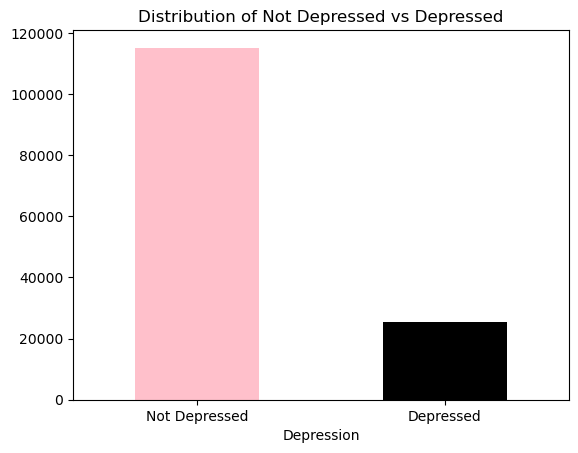

In [6809]:
target_counts = data['Depression'].value_counts()
target_counts.plot(kind='bar', color=['pink', 'black'])
plt.xticks(ticks=[0, 1], labels=['Not Depressed', 'Depressed'], rotation=0)
plt.title('Distribution of Not Depressed vs Depressed')
plt.show()

You can tell that there is a significant imbalance between depressed and not depressed. 

# Pre-processing

Dropping the Id column

In [6810]:
def dropId(data):
    data = data.drop(columns=["id"])
    return data

Encoding the name column, Replacing each name with its frequency in the dataset

In [6811]:
def name_freq(data):
    data["Name"] = data["Name"].map(data["Name"].value_counts())
    return data

Encoding gender column 0/1

In [6812]:
def gender_encode(data):
    data["Gender"] = data["Gender"].map({"Female": 0, "Male": 1 })
    return data

Age, changing the type

In [6813]:
def age_integer(data):
    data["Age"] = data["Age"].astype(int)
    return data

Academic Preessure, inserting 0 in the empty slots

In [6814]:
def academic_pressure(data):
    data["Academic Pressure"] = np.where(
        data["Academic Pressure"].isnull(), 0,
        data["Academic Pressure"]
    )
    return data

Family History of Mental Illnes. -> 0/1

In [6815]:
def family_mental_illness(data):
    data["Family History of Mental Illness"] = np.where(
        data["Family History of Mental Illness"] == "No", 0,
        np.where(
            data["Family History of Mental Illness"] == "Yes", 1,
            data["Family History of Mental Illness"]
        )
    )
    return data

Have you ever had suicidal thoughts? -> 0/1

In [6816]:
def suicidal_thoughts(data):
    data["Have you ever had suicidal thoughts ?"] = np.where(
        data["Have you ever had suicidal thoughts ?"] == "No", 0,
        np.where(
            data["Have you ever had suicidal thoughts ?"] == "Yes", 1,
            data["Have you ever had suicidal thoughts ?"]
        )
    )
    return data

Financial stress

In [6817]:
def financial_stress(data):
    data["Financial Stress"] = np.where(
        data["Financial Stress"].isnull(), round(data["Financial Stress"].mean()), data["Financial Stress"]
    )
    return data

Working Professional or Student. -> 0/1

In [6818]:
def working_or_student(data):
    data["Working Professional or Student"] = np.where(
        data["Working Professional or Student"] == "Working Professional", 0,
        np.where(
            data["Working Professional or Student"] == "Student", 1,
            data["Working Professional or Student"]
        )
    )       
    return data

Profession. Inserting Student in the empty slots if the sample is a student and missing profession if it is empty and the sample is not a student. also inserting "Missing Profession" in the professions that has less than 10 occurrences in the dataset because the majority of these are wrong information.

In [6819]:
def profession(data):
    # Count occurrences of each profession
    profession_counts = data["Profession"].value_counts()
    
    # Update the "Profession" column
    data["Profession"] = np.where(
        data["Profession"].isnull() & (data["Working Professional or Student"] == 1),
        "Student",
        np.where(
            data["Profession"].isnull() & (data["Working Professional or Student"] == 0), 
            "Missing Profession", 
            np.where(
                data["Profession"].map(profession_counts) < 6,  # If occurrence < 10, set to "Missing Profession"
                "Missing Profession",
                data["Profession"]
            )
        )
    )
    return data


Categorizing Professions and giving each category a number. the number is a rating from 0 to 10 on how happy people are in given categories. We used chatGPT to rate them based on different logical points. see professions_mapping dictionary for description of the ratings.

In [6820]:
def categorize_profession(profession):
    if pd.isna(profession) or "missing" in profession.lower():
        return "Unknown"
    
    profession = profession.lower().strip()

    # Technology
    tech_keywords = ["software", "data scientist", "ux/ui", "developer", "engineer"]
    if any(keyword in profession for keyword in tech_keywords):
        return "Technology"

    # Finance
    finance_keywords = ["accountant", "financial", "investment", "banker", "analyst"]
    if any(keyword in profession for keyword in finance_keywords):
        return "Finance"

    # Healthcare
    healthcare_keywords = ["doctor", "pharmacist", "dentist", "nurse"]
    if any(keyword in profession for keyword in healthcare_keywords):
        return "Healthcare"

    # Education
    education_keywords = ["teacher", "professor", "educational"]
    if any(keyword in profession for keyword in education_keywords):
        return "Education"

    # Engineering
    engineering_keywords = ["civil engineer", "mechanical engineer", "architect"]
    if any(keyword in profession for keyword in engineering_keywords):
        return "Engineering"

    # Marketing & Sales
    marketing_keywords = ["marketing", "sales", "digital marketer", "content writer"]
    if any(keyword in profession for keyword in marketing_keywords):
        return "Marketing/Sales"

    # Trade & Manual Work
    trade_keywords = ["electrician", "plumber", "chef", "mechanic"]
    if any(keyword in profession for keyword in trade_keywords):
        return "Trade"

    # Legal
    legal_keywords = ["lawyer", "judge", "legal"]
    if any(keyword in profession for keyword in legal_keywords):
        return "Legal"

    # Consulting
    consulting_keywords = ["consultant", "business analyst"]
    if any(keyword in profession for keyword in consulting_keywords):
        return "Consulting"

    # Other / Unknown
    return "Other"

def Prefession_categorization(data):
    # Apply categorization
    data["Profession_Category"] = data["Profession"].apply(categorize_profession)

    # Encoding Options

    ## Option 1: Ordinal Encoding (useful if there's a natural order)
    profession_mapping = {
    "Unknown": 0,           # No data on job satisfaction
    "Other": 4,             # Mixed bag, depends on the job
    "Trade": 6,             # Skilled trades often provide satisfaction, but physically demanding
    "Marketing/Sales": 5,   # High variability, stressful but rewarding
    "Consulting": 5,        # High pay but often high stress & long hours
    "Education": 7,         # Fulfilling, but pay can be low and stress can be high
    "Finance": 6,           # High pay, but long hours and stress
    "Engineering": 7,       # Good pay, problem-solving, but deadlines can be stressful
    "Healthcare": 6,        # Rewarding but high stress and burnout risk
    "Legal": 5,             # High salary, but stressful and demanding
    "Technology": 8         # High salary, flexibility, remote work options
}


    data["Profession_Encoded"] = data["Profession_Category"].map(profession_mapping)

    data["Profession"] = data["Profession_Encoded"]

    data = data.drop(columns=["Profession_Encoded", "Profession_Category"])
    return data
    ## Option 2: One-Hot Encoding (better for categorical data)
    # data = pd.get_dummies(data, columns=["Profession_Category"], prefix="Profession")


Work Pressure

In [6821]:
def work_pressure(data):
    data["Work Pressure"] = np.where(
        data["Work Pressure"].isnull(), 0.0, data["Work Pressure"]
    )
    return data

CGPA

In [6822]:
def cgpa(data):
    data["CGPA"] = np.where(
        data["CGPA"].isnull(), round(data["CGPA"].mean(), 2), data["CGPA"]
    )
    return data

Study- and Job Satisfaction

In [6823]:
def satisfaction(data):
    satisfaction = np.where(
        data["Study Satisfaction"].notnull(), data["Study Satisfaction"], np.where(
            data["Job Satisfaction"].notnull(), data["Job Satisfaction"], 0
        )
    )
    data["Job Satisfaction"] = satisfaction
    data = data.drop(columns="Study Satisfaction")
    data.rename(columns={"Job Satisfaction": "Satisfaction"}, inplace=True)
    return data

Sleep Duration

In [6824]:
def sleep_duration(data):
    data["Sleep Duration"] = np.where(
        data["Sleep Duration"] == "Less than 5 hours", 1, np.where(
            data["Sleep Duration"] == "5-6 hours", 2, np.where(
                data["Sleep Duration"] == "7-8 hours", 3, np.where(
                    data["Sleep Duration"] == "More than 8 hours", 4, 1
                )
            )
        )
    )
    return data

Dietary Habits

In [6825]:
def diet(data):
    data["Dietary Habits"] = np.where(
        data["Dietary Habits"] == "Healthy", 2, np.where(
            data["Dietary Habits"] == "Moderate", 1, np.where(
                data["Dietary Habits"] == "Unhealthy", 0, 1
            )
        )
    )
    return data

In [6826]:
def categorize_degree(degree):

    """
    Categorizes the differnet degrees into Schoo, Bachelors, Masters, Doctrate, professional and other
    """
    
    degree = str(degree).strip().lower()

    # School-Level
    if "class 11" in degree or "class 12" in degree:
        return "School"

    # Bachelor's Degrees
    bachelor_keywords = ["b.", "b ", "bachelor", "bcom", "bsc", "btech", "be", "bba", "bca", "ba", "b.ed", "b.arch"]
    if any(keyword in degree for keyword in bachelor_keywords):
        return "Bachelors"

    # Master's Degrees
    master_keywords = ["m.", "m ", "master", "mba", "mcom", "msc", "mtech", "me", "mca", "m.ed", "mpharm", "m.arch"]
    if any(keyword in degree for keyword in master_keywords):
        return "Masters"

    # Doctoral Degrees
    if "phd" in degree:
        return "Doctorate"

    # Professional Degrees
    professional_keywords = ["mbbs", "md", "llb", "llm"]
    if any(keyword in degree for keyword in professional_keywords):
        return "Professional"

    # Unknown / Noisy Data
    return "Other"

def degree(data):
    
    # Apply categorization
    data["Degree"] = data["Degree"].apply(categorize_degree)


    # Define an ordinal mapping
    degree_mapping = {
        "School": 1,
        "Bachelors": 2,
        "Masters": 3,
        "Professional": 4,
        "Doctorate": 5,
        "Other": 0  # Keep 'Other' at the highest level or remove it depending on the approach
    }

    # Apply mapping
    data["Degree"] = data["Degree"].map(degree_mapping)

    return data 



City

In [6827]:
# Load city data
city_data_path = "./Data/indian_cities_data.csv"
df_cities = pd.read_csv(city_data_path)

def city_one_hot(data):
    # Find the index of the "City" column
    city_index = data.columns.get_loc("City")

    # Merge the data with city information, excluding "Main Language"
    merged_data = data.merge(df_cities.drop(columns=["Main Language"]), on="City", how="left")

    # Calculate the mean values for missing cities
    mean_values = merged_data[["Population", "Density (per km²)", "Literacy Rate (%)", "Sex Ratio"]].mean()

    # Replace NaN values with the mean of the respective column
    merged_data.fillna(mean_values, inplace=True)

    # Drop the original "City" column
    merged_data.drop(columns=["City"], inplace=True)

    # Reorder columns to place new city-related columns where "City" was
    city_columns = ["Population", "Density (per km²)", "Literacy Rate (%)", "Sex Ratio"]
    cols = merged_data.columns.tolist()

    # Move the new city-related columns to the correct index
    for col in reversed(city_columns):
        cols.insert(city_index, cols.pop(cols.index(col)))

    # Reorder the dataframe
    merged_data = merged_data[cols]

    return merged_data


Pre-processing function:

In [6828]:
def pre_processing(data):

    data = dropId(data)
    data = name_freq(data)
    data = gender_encode(data)
    data = age_integer(data)
    data = academic_pressure(data)
    data = family_mental_illness(data)
    data = suicidal_thoughts(data)
    data = working_or_student(data)
    data = profession(data)
    data = work_pressure(data)
    data = cgpa(data)
    data = satisfaction(data)
    data = sleep_duration(data)
    data = diet(data)
    data = degree(data)
    data = Prefession_categorization(data)
    data = city_one_hot(data)
    data = financial_stress(data)
    return data

training_data = pre_processing(data)
test_data = pre_processing(test)
test_data.to_csv("test_data.csv", index=False)

Here is The function for Normalizing (0-1) the dataset. This is necessary or helpful if we want to use:

| Learning Algorithm |
|--------------------|
| Logistic Regression |
| SVM |
| Neural Network - better |
| K-Means |

In [6829]:
def normalize_dataset(training_data, test_data, columns_to_scale):
    scaler = MinMaxScaler()
    scaler.fit(training_data[columns_to_scale])
    training_data[columns_to_scale] = scaler.transform(training_data[columns_to_scale])
    test_data[columns_to_scale] = scaler.transform(test_data[columns_to_scale])
    return training_data, test_data

Here is The function for Standardising the dataset. This is necessary or helpful if we want to use:

| Learning Algorithm |
|--------------------|
| Logistic Regression |
| SVM - better |
| Neural Network |
| PCA |

In [6830]:
def standardize_dataset(training_data, test_data, columns_to_scale):
    scaler = StandardScaler()
    scaler.fit(training_data[columns_to_scale])
    training_data[columns_to_scale] = scaler.transform(training_data[columns_to_scale])
    test_data[columns_to_scale] = scaler.transform(test_data[columns_to_scale])
    return training_data, test_data

The columns that needs to be scaled:

In [6831]:
columns_to_scale = ["Population", "Density (per km²)", "Literacy Rate (%)", "CGPA", "Work/Study Hours"]

def scale(method: str, training_data, test_data):
    if method == "Standardize":
        training_data, test_data = standardize_dataset(training_data, test_data, columns_to_scale)
    else:
        training_data, test_data = normalize_dataset(training_data, test_data, columns_to_scale)
    return training_data, test_data

Splitting the dataset into Train and val, also extracting the labels.

In [6832]:
def split_training_data(seed=0, train_size=0.8, data=training_data):
    np.random.seed(seed)
    X = data.drop(columns=["Depression"])
    y = data["Depression"]
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_size, random_state=seed, stratify=y)
    return X_train, X_val, y_train, y_val

Trying out Random forest classifier

Test method to be used anytime you want to try your model. Prints the submission in "submission.csv" in the working directory if you want to submit, but also tests it on the validation dataset

In [6833]:
def test_model(model, test_data, X_val, y_val, test_or_val="val"):
    if test_or_val == "test":
        predictions = model.predict(test_data)

        submission = pd.DataFrame({
            "id": test["id"], 
            "Depression": predictions
        })
        submission.to_csv("submission.csv", index=False)
        print("test successfully executed, results in submission.csv")
    elif test_or_val == "val":
        predictions = model.predict(X_val)
        accuracy = accuracy_score(predictions, y_val)
        return accuracy


# Random Forest classifier

In [6834]:
def Random_forest(seed, X_train, y_train):
    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }

    param_grid = {
        "n_estimators": [200],
        "max_depth": [20],
        "min_samples_split": [5],
        "min_samples_leaf": [1]
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    rf = RandomForestClassifier(random_state=seed)

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=kf,
        scoring="accuracy",
        n_jobs=-1,  # Use all available CPU cores
        verbose=1   # Shows progress
    )

    # No scaling required

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    print("Best Hyperparameters:", best_params)
    
    model = RandomForestClassifier(max_depth=best_params["max_depth"], 
                            min_samples_leaf=best_params["min_samples_leaf"],
                            min_samples_split=best_params["min_samples_split"],
                            n_estimators=best_params["n_estimators"],
                            class_weight="balanced"
                            )

    model.fit(X_train, y_train)
    
    return model


# rf_training_data, rf_test_data = scale("Standardize", training_data, test_data)
X_train, X_val, y_train, y_val = split_training_data(0, data=training_data)
# model = Random_forest(0, X_train, y_train)
# test_model(model, rf_test_data, X_val, y_val, "val")

# Improved Random Forest classifier - Magnus Paper implementation

[Improved Random forest paper](https://www.sciencedirect.com/science/article/pii/S0957417423020511) <--- link

## Split into three equal test sets

In [6835]:
X_train, X_reserved, y_train, y_reserved = split_training_data(0, data=training_data)

# split the reserved data into three equal parts
reserved_size = len(X_reserved) // 3
X_res1 = X_reserved.iloc[:reserved_size]
X_res2 = X_reserved.iloc[reserved_size:2*reserved_size]
X_res3 = X_reserved.iloc[2*reserved_size:]
y_res1 = y_reserved.iloc[:reserved_size]
y_res2 = y_reserved.iloc[reserved_size:2*reserved_size]
y_res3 = y_reserved.iloc[2*reserved_size:]

## Training a pool of Decision trees with bagging

In [6836]:
def make_trees(N_final, m, max_depth, min_samples_leaf, min_samples_split):
    
    N_pool = int(N_final * (1 + m)) # total number of trees to train

    # list to store the trained trees. 
    forest_pool = []

    for i in range(N_pool):
        X_boot, y_boot = resample(X_train, y_train, random_state=i) # different random_state for each sampling to ensures that each bootstrap sample is different
        clf = DecisionTreeClassifier(random_state=i, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
        clf.fit(X_boot, y_boot)
        forest_pool.append(clf)
        
    return forest_pool


## Evaluating each Decisiontree

In [6837]:
def average_classification_accuracy(clf: DecisionTreeClassifier):
    """
    Calculates the average classification accuracy of a decision tree 
    just how the paper describes it.
    """
    accuracy1 = accuracy_score(y_res1, clf.predict(X_res1))
    accuracy2 = accuracy_score(y_res2, clf.predict(X_res2))
    accuracy3 = accuracy_score(y_res3, clf.predict(X_res3))
    return np.mean([accuracy1, accuracy2, accuracy3])


def make_tree_sorted(forest_pool):
    # A list of tuples (tree_index, clf, average_classification_accuracy)
    tree_info = []

    # aplies the average classification accuracy information to each tree in the new list tree_info
    for index, clf in enumerate(forest_pool):
        aca = average_classification_accuracy(clf)
        tree_info.append((index, clf, aca))

    # Sorts the trees in descending order based on the average classification accuracy
    tree_info_sorted = sorted(tree_info,key=lambda x: x[2], reverse=True)
    
    return tree_info_sorted


## Measuring Correlation between decision trees

In [6838]:
def improved_similarity(clf1, clf2):
    """
    Calculates the improved dot product based method to measure the 
    correlation between trees. 

    Takes in two Decision trees and returns an angle representing the correletion

    The paper only considers the feature space meaning the specific features each tree is using, not considering the feature importance.
    """

    # The sets of which features the trees are using
    Wi = set(clf1.tree_.feature)
    Wi.discard(-2) # removing leaves
    Wj = set(clf2.tree_.feature)
    Wj.discard(-2) # removing leaves

    # calculates the numerator of the improved dot product based method in the paper.
    numerator = len(Wi.intersection(Wj))

    # calculates the denominator of the improved dot product based method in the paper.
    denominator = np.sqrt(len(Wi) * len(Wj))

    if denominator == 0:
        return 90  # orthogonal if there's no shared features

    # Cosine similarity normalization
    improved_dot_product = numerator / denominator

    # Clip for numerical stability
    improved_dot_product = np.clip(improved_dot_product, -1.0, 1.0)

    # Puts the whole method for measuring the correlation between two trees. 
    angle_correlation = np.degrees(np.arccos(improved_dot_product))
    
    return angle_correlation

## Measure the correlation between the trees and mark the bad ones as deletable while also hypertuning the threshold
I figured that the correlation angles could differ alot between each model, So i found it reasonable to find the values to tune on based on the mean correlation angle of all the correlations. 

In [6839]:
def correlation_test(tree_info_sorted, N_final):
    """"
    Finds the correlation between trees using the improved_similarity() function. 
    Returns a mask that can be used to filter out what trees are marked as deletable.
    """

    # The matrix keeping track of the correlations between trees.
    correlation_matrix = np.zeros((len(tree_info_sorted), len(tree_info_sorted)))

    # Finds the correlation between all the trees, adding them to the matrix and marking the 
    # tree with the lowest accuracy among the pairs with too high correlations as deletable with the binary mask marked_mask.
    for i in range(len(tree_info_sorted)):
        for j in range(len(tree_info_sorted)):
            angle = improved_similarity(tree_info_sorted[i][1], tree_info_sorted[j][1])
            correlation_matrix[i, j] = angle
            correlation_matrix[j, i] = angle

    (width, height) = np.shape(correlation_matrix)
    # Hypertune the threshold, tuned differently for each model.
    mean_threshold, min_threshold = find_mean_without_diagonal(width, height, correlation_matrix)
    min_to_mean_threshold_range = mean_threshold - min_threshold
    max_threshold = np.max(correlation_matrix)
    mean_to_max_threshold_range = max_threshold - mean_threshold
    thresholds = [
       mean_threshold + mean_to_max_threshold_range*0.5,
       min_threshold + min_to_mean_threshold_range*0.5,
       mean_threshold,
       mean_threshold + mean_to_max_threshold_range*0.25,
       min_threshold + min_to_mean_threshold_range*0.25
    ]

    best_threshold = 0
    best_score = 0
    best_mask = []

    # Using the grid search method to find the best threshold
    for t, threshold in enumerate(thresholds):

        # The mask representing the trees marked as "deletable" in the tree_info_sorted list
        marked_mask = np.zeros(len(tree_info_sorted))
        tree_info_sorted_temp = tree_info_sorted.copy()

        for i in range(len(tree_info_sorted_temp)):
            for j in range(len(tree_info_sorted_temp)):
                angle = correlation_matrix[i, j]

                if angle < threshold: # if the trees are too correlated
                    if i == j: # skip when it is the same tree
                        continue
                    elif tree_info_sorted_temp[i][2] < tree_info_sorted_temp[j][2]:
                        marked_mask[i] = 1 # mark tree[i] as 1 for "deletable"
                    else:
                        marked_mask[j] = 1 # mark tree[j] as 1 for "deletable"

        # Testing the accuracy of the model with this threshold using the three reserved datasets.
        tree_info_sorted_temp = filter_out_trees(tree_info_sorted_temp, marked_mask, N_final)
        average_accuracy = 0
        trees = [tree_information[1] for tree_information in tree_info_sorted_temp]
        for X, y in [(X_res1, y_res1),(X_res2, y_res2), (X_res3, y_res3)]:
            predictions = np.array([tree.predict(X) for tree in trees])
            majority_vote, _ = mode(predictions, axis=0, keepdims=True)
            majority_vote = majority_vote.flatten()
            score = accuracy_score(majority_vote, y)
            average_accuracy += score
        average_accuracy = average_accuracy/3
        if average_accuracy > best_score:
            best_mask = marked_mask
            best_threshold = threshold
            best_score = average_accuracy

    return best_mask

def find_mean_without_diagonal(width, height, matrix):
    """
    Finds the mean and min while excluding the times when a tree is compared to itself because that as irrelevant and will pull the mean and min lower than whats correct.
    """
    
    mean = 0
    min = 180
    for i in range(width):
        for j in range(height):
            if i == j:
                continue
            else:
                angle = matrix[i][j]
                mean += angle
                if angle < min:
                    min = angle
    mean = mean / (width*height - width)
    return mean, min


# Delete trees

In [6840]:
def delete_with_accuracy(tree_info_sorted_temp, preset):
    """
    Sequentially removing trees with the lowest average classification accuracy until the preset number is met
    """
    print("There were too few in the deletable list, deleting based on accuracy score.")
    idx = len(tree_info_sorted_temp) - 1
    while len(tree_info_sorted_temp) > preset and idx >= 0:
        tree_info_sorted_temp.pop(idx)
        idx -= 1
    
    
    return tree_info_sorted_temp


def filter_out_trees(tree_info_sorted_for_deletion, mask, preset):
    """
    Removes trees primarily based on the deletable trees, but if the preset number isn't met when all the deletable trees are deleted,
    trees will be removed based solely on their accuracy score. 
    """

    mask_temp = list(mask)
    
    idx = len(tree_info_sorted_for_deletion) - 1
    while (len(tree_info_sorted_for_deletion) > preset) and idx >= 0:
        if 1 not in mask_temp[:idx + 1]:
            tree_info_sorted_for_deletion = delete_with_accuracy(tree_info_sorted_for_deletion, preset)
            break
        if mask_temp[idx] == 1:
            tree_info_sorted_for_deletion.pop(idx)
        idx -= 1

    return tree_info_sorted_for_deletion

## Ensemble the trees to form and implement the improved random forest class.

In [6856]:
class ImprovedRandomForest:
    def __init__(self, N_final, m, max_depth, min_samples_leaf, min_samples_split):
        self.N_final = N_final
        self.m = m
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self.tree_info_sorted = make_tree_sorted(make_trees(self.N_final, self.m, self.max_depth, self.min_samples_leaf, self.min_samples_split))
        self.deletable_mask = correlation_test(self.tree_info_sorted, N_final)
        self.tree_info_sorted = filter_out_trees(self.tree_info_sorted, self.deletable_mask, self.N_final)
        self.trees = [tree_information[1] for tree_information in self.tree_info_sorted]

    def get_trees(self):
        return self.trees

    def predict(self, dataset):
        predictions = np.array([tree.predict(dataset) for tree in self.trees])
        majority_vote, _ = mode(predictions, axis=0, keepdims=True)
        return majority_vote.flatten()

## Hypertune parameters with grid search nethod

In [6842]:
parameters = {
    "N_final": [150, 200, 250, 300, 350],
    "m": [0.15],
    "max_depth": [9],
    "min_samples_leaf": [4],
    "min_samples_split": [2]
}

train_accuracies = []
val_accuracies = []
n_estimators = parameters["N_final"]

# The best parameters from tuning
# parameters = {
#     "N_final": [200],
#     "m": [0.5],
#     "max_depth": [12],
#     "min_samples_leaf": [4],
#     "min_samples_split": [2]
# }

def hypertuned_model(parameters: dict):

    # Gives an overview of the computational cost of the hypertuning - for time estamation
    total_candidates = 1
    for p in parameters:
        total_candidates = total_candidates * len(parameters[p])
    print("The amount of total candidates: ", total_candidates)

    best_parameters = {
        "N_final": None,
        "m": None,
        "max_depth": None,
        "min_samples_leaf": None,
        "min_samples_split": None
    }
    best_accuracy_score = 0.0
    best_model = None
    candidates = total_candidates
    for N_final in parameters["N_final"]:
        for m in parameters["m"]:
            for max_depth in parameters["max_depth"]:
                for min_samples_leaf in parameters["min_samples_leaf"]:
                    for min_samples_split in parameters["min_samples_split"]:
                        print(f"Testing the parameters: {N_final}, {m}, {max_depth}, {min_samples_leaf}, {min_samples_split}.")
                        model = ImprovedRandomForest(N_final, m, max_depth, min_samples_leaf, min_samples_split)

                        # validationset score
                        val_accuracy = test_model(model, test_data, X_val, y_val, "val")
                        val_accuracies.append(val_accuracy)

                        # trainingset score
                        train_accuracy = test_model(model, test_data, X_train, y_train, "val")
                        train_accuracies.append(train_accuracy)

                        if val_accuracy > best_accuracy_score:
                            print(f"Best parameters so far: {N_final}, {m}, {max_depth}, {min_samples_leaf}, {min_samples_split}, with accuracy: {val_accuracy}")
                            best_parameters = {
                                "N_final": N_final,
                                "m": m,
                                "max_depth": max_depth,
                                "min_samples_leaf": min_samples_leaf,
                                "min_samples_split": min_samples_split
                            }
                            best_model = model
                            best_accuracy_score = val_accuracy
                        candidates -= 1
                        print(f"Remaining candidates: {candidates}/{total_candidates}")
    print(f"The best performing model with an accuracy score: {best_accuracy_score}, had these parameters:")
    print(f"N_final: {best_parameters["N_final"]}\nm: {best_parameters["m"]}\nmax_depth: {best_parameters["max_depth"]}\nmin_samples_leaf: {best_parameters["min_samples_leaf"]}\nmin_samples_split: {best_parameters["min_samples_split"]}")
    return best_model, best_parameters, best_accuracy_score

In [6843]:
tuned_model, the_best_parameters, the_best_accuracy_score = hypertuned_model(parameters)

The amount of total candidates:  5
Testing the parameters: 150, 0.15, 9, 4, 2.
Best parameters so far: 150, 0.15, 9, 4, 2, with accuracy: 0.9347903340440654
Remaining candidates: 4/5
Testing the parameters: 200, 0.15, 9, 4, 2.
Best parameters so far: 200, 0.15, 9, 4, 2, with accuracy: 0.9349324804548685
Remaining candidates: 3/5
Testing the parameters: 250, 0.15, 9, 4, 2.
Best parameters so far: 250, 0.15, 9, 4, 2, with accuracy: 0.9351101634683724
Remaining candidates: 2/5
Testing the parameters: 300, 0.15, 9, 4, 2.
Remaining candidates: 1/5
Testing the parameters: 350, 0.15, 9, 4, 2.
Best parameters so far: 350, 0.15, 9, 4, 2, with accuracy: 0.9351457000710732
Remaining candidates: 0/5
The best performing model with an accuracy score: 0.9351457000710732, had these parameters:
N_final: 350
m: 0.15
max_depth: 9
min_samples_leaf: 4
min_samples_split: 2


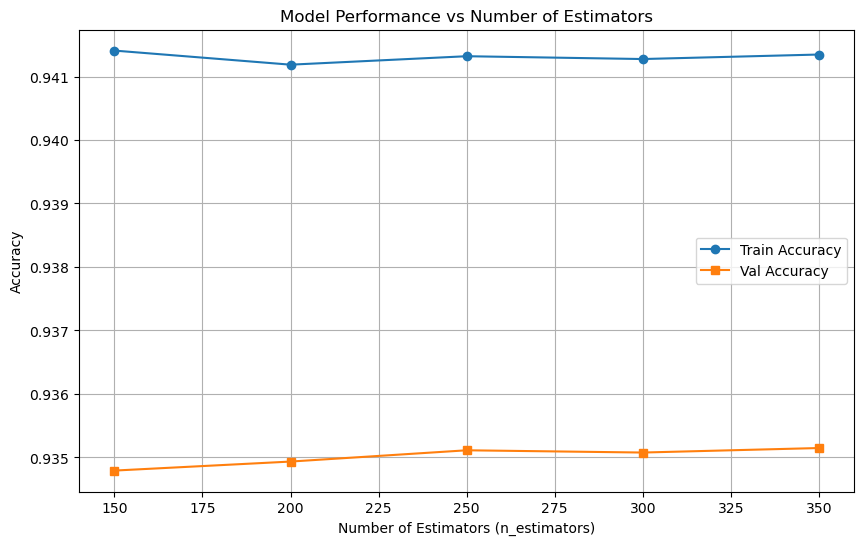

In [6844]:
plt.figure(figsize=(10, 6))
plt.plot(n_estimators, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(n_estimators, val_accuracies, label='Val Accuracy', marker='s')

plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Model Performance vs Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()

## Test the tuned model on validation data

In [6845]:
test_model(tuned_model, test_data, X_val, y_val, "val")

0.9351457000710732

# Test the tuned model on the test data

In [6846]:
# test_model(tuned_model, test_data, X_val, y_val, "test")

7
12
17
22
27
32
37
42
47
9
9


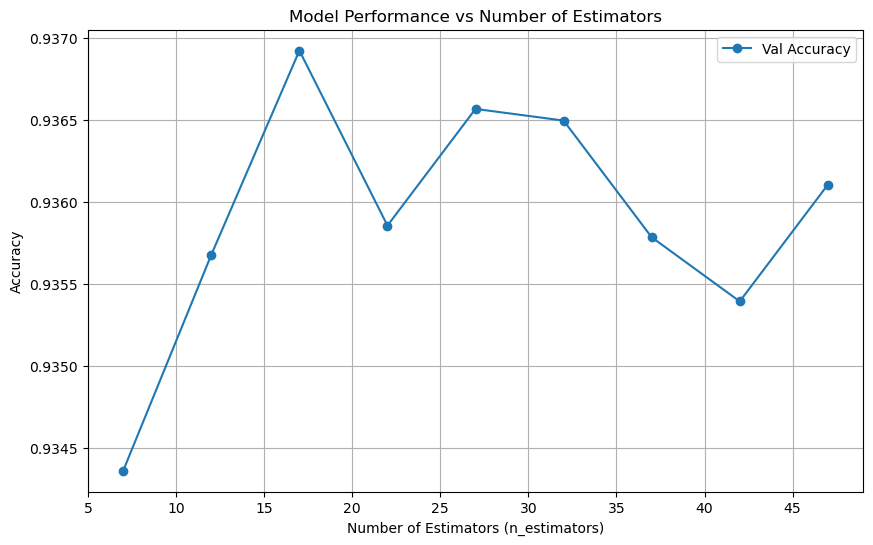

In [ ]:
trymodel = ImprovedRandomForest(50, 0.3, 12, 2, 2)

forest_trees = list(trymodel.get_trees())

estimators = [7, 12, 17, 22, 27, 32, 37, 42, 47]
train_a = []
val_a = []

for e in estimators:
    print(e)
    predictions = np.array([tree.predict(X_val) for tree in forest_trees[:e]])
    majority_vote, _ = mode(predictions, axis=0, keepdims=True)
    the_vote = majority_vote.flatten()
    val_a.append(accuracy_score(the_vote, y_val))


plt.figure(figsize=(10, 6))
# plt.plot(n_estimators, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(estimators, val_a, label='Val Accuracy', marker='o')

plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Model Performance vs Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()



50
75
100
125
150
175
190


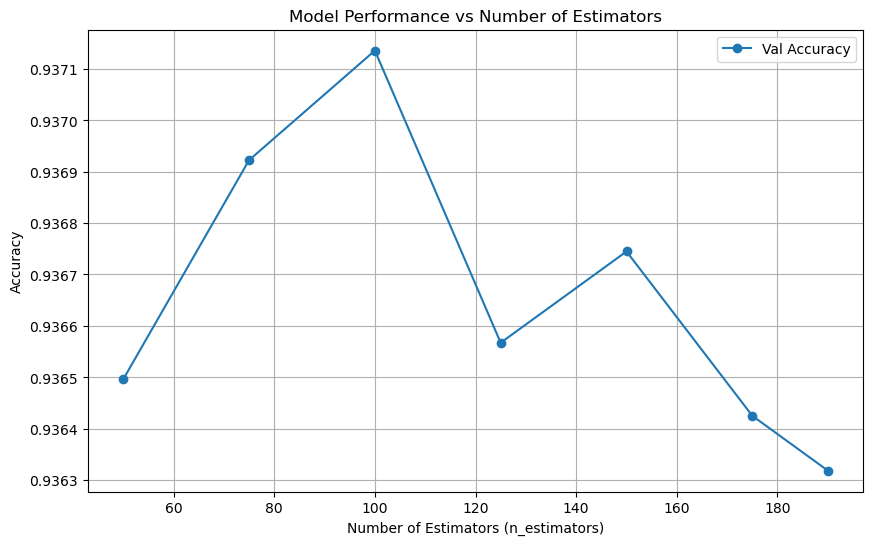

In [6864]:
trymodel = ImprovedRandomForest(200, 0.5, 14, 2, 2)

forest_trees = list(trymodel.get_trees())

estimators = [50, 75, 100, 125, 150, 175, 190]
train_a = []
val_a = []

for e in estimators:
    print(e)
    predictions = np.array([tree.predict(X_val) for tree in forest_trees[:e]])
    majority_vote, _ = mode(predictions, axis=0, keepdims=True)
    the_vote = majority_vote.flatten()
    val_a.append(accuracy_score(the_vote, y_val))


plt.figure(figsize=(10, 6))
# plt.plot(n_estimators, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(estimators, val_a, label='Val Accuracy', marker='o')

plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Model Performance vs Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()